In [7]:
# importing required packages
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import re
import matplotlib.pyplot as plt

# installing unipressed package
# Unipressed (Uniprot REST) is an API client for the protein database Uniprot. 
# pip install unipressed

from unipressed import IdMappingClient
import time

In [2]:
# loading the RBP dataset

# path to the file
path = "ATtRACT_db.txt"

# Reading the RNA binding protein data from "ATtRACT_db.txt" into a DataFrame. The file was downloaded from ATtract database
rbp_df = pd.read_csv(path, sep='\t')

# filtering the dataframe to only include home_sapiens
rbp_df = rbp_df[rbp_df['Organism'] == 'Homo_sapiens']

# print
rbp_df

,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Matrix_id,Score
6,A1CF,ENSG00000148584,no,Homo_sapiens,UGAUCAGUAUA,11,UV cross-linking,R,10669759,UV cross-linking,RRM,110,1.000000**
7,A1CF,ENSG00000148584,no,Homo_sapiens,AUAAUUA,7,RNAcompete,C,23846655,RNAcompete,RRM,M001_0.6,0.126952
8,A1CF,ENSG00000148584,no,Homo_sapiens,UUAAUUA,7,RNAcompete,C,23846655,RNAcompete,RRM,M001_0.6,0.126411
9,A1CF,ENSG00000148584,no,Homo_sapiens,AUAAUUG,7,RNAcompete,C,23846655,RNAcompete,RRM,M001_0.6,0.189114**
10,A1CF,ENSG00000148584,no,Homo_sapiens,UUAAUUG,7,RNAcompete,C,23846655,RNAcompete,RRM,M001_0.6,0.188308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4877,NOVA1,ENSG00000139910,no,Homo_sapiens,UCAC,4,RNA affinity binding assays,AEDB,15367696,other,KH,1394,1.000000**
4878,SRSF2,ENSG00000161547,no,Homo_sapiens,GAAAGGAGA,9,RNA isolation and Western blot,AEDB,11847131;9343212,other,RRM,1395,1.000000**
4879,HNRNPAB,ENSG00000197451,no,Homo_sapiens,AUAGCA,6,In vitro splicing assays,AEDB,12426391,other,RRM,1396,1.000000**
4880,HNRNPA1,ENSG00000135486,no,Homo_sapiens,UAGG,4,Immunoprecipitation;UV cross-linking,AEDB,15506926,UV cross-linking,RRM,1397,1.000000**


In [3]:
# loading the viral genome

# path
viral_genome_path = 'sequence.fasta'

# reading the fasta file
viral_genome = SeqIO.read(viral_genome_path, 'fasta')

In [4]:
# Initializing an empty DataFrame to store the results
mapped_df = pd.DataFrame(columns=['RBP_name', 'Motif_sequence', 'Motif_length', 'Start', 'Stop'])

# Iterating through each row of the RBP dataframe
for index, row in rbp_df.iterrows():
    
    # Extracting the original motif sequence
    original_motif = row['Motif']
    
    # Converting 'U'(uracil) to 'T'(Thymine) in the motif
    rbp_motif = Seq(original_motif).replace('U', 'T')

    # Finding occurrences of the motif in the viral genome using re.finditer
    occurrences = [match.span() for match in re.finditer(str(rbp_motif), str(viral_genome.seq))]

    # Add the information to the final_df DataFrame
    for start, stop in occurrences:
        
        # calculating the motif length
        motif_length = stop - start
        
        # adding the information to the mapped df
        mapped_df = mapped_df.append({
            'RBP_name': row['Gene_name'],
            'Motif_sequence': original_motif,
            'Motif_length': motif_length,
            'Start': start + 1,  # Adjust start position
            'Stop': stop + 1  # Adjust stop position
        }, ignore_index=True)

In [5]:
# print
mapped_df

,RBP_name,Motif_sequence,Motif_length,Start,Stop
0,A1CF,AUAAUUA,7,129,136
1,A1CF,AUAAUUA,7,7367,7374
2,A1CF,AUAAUUA,7,21499,21506
3,A1CF,AUAAUUA,7,22824,22831
4,A1CF,AUAAUUA,7,22908,22915
...,...,...,...,...,...
29935,PTBP1,UUCUUC,6,26080,26086
29936,PTBP1,UUCUUC,6,26442,26448
29937,PTBP1,UUCUUC,6,26875,26881
29938,PTBP1,UUCUUC,6,29213,29219


In [14]:
# creating a list of all the unique RBPs from the mapped dataframe
rbp_names = mapped_df['RBP_name'].unique()

In [15]:
# creating a empty list to store the results
results_list = []

# Iterating over each RBP and performing ID mapping
for rbp_name in rbp_names:
    
    # Submitting the request for ID mapping for the current RBP using IdMappingClient function from unipressed
    request = IdMappingClient.submit(source="GeneCards", dest="UniProtKB", ids={rbp_name})

    # Waitting for a short time to allow the request to complete
    time.sleep(1.0)

    # Iterating over the results and appending them to the list
    for result in request.each_result():
        results_list.append(result)

# Creating a DataFrame from the results list
id_mapping_df = pd.DataFrame(results_list, columns=['from', 'to'])

# renaming columns to match your desired output
id_mapping_df.columns = ['RBP', 'UniProt_ID']

In [16]:
# merging the ID mapping DataFrame with the original DataFrame to add uniport_id column
final_df = pd.merge(mapped_df, id_mapping_df, how='left', left_on='RBP_name', right_on='RBP')

# Dropping the redundant 'RBP' column
final_df = final_df.drop(columns=['RBP'])

final_df

,RBP_name,Motif_sequence,Motif_length,Start,Stop,UniProt_ID
0,A1CF,AUAAUUA,7,129,136,Q9NQ94
1,A1CF,AUAAUUA,7,7367,7374,Q9NQ94
2,A1CF,AUAAUUA,7,21499,21506,Q9NQ94
3,A1CF,AUAAUUA,7,22824,22831,Q9NQ94
4,A1CF,AUAAUUA,7,22908,22915,Q9NQ94
...,...,...,...,...,...,...
30966,PTBP1,UUCUUC,6,26080,26086,P26599
30967,PTBP1,UUCUUC,6,26442,26448,P26599
30968,PTBP1,UUCUUC,6,26875,26881,P26599
30969,PTBP1,UUCUUC,6,29213,29219,P26599


In [17]:
# Counting the occurrences of each unique RBP's motif in the given viral genome
rbp_counts = final_df['RBP_name'].value_counts()

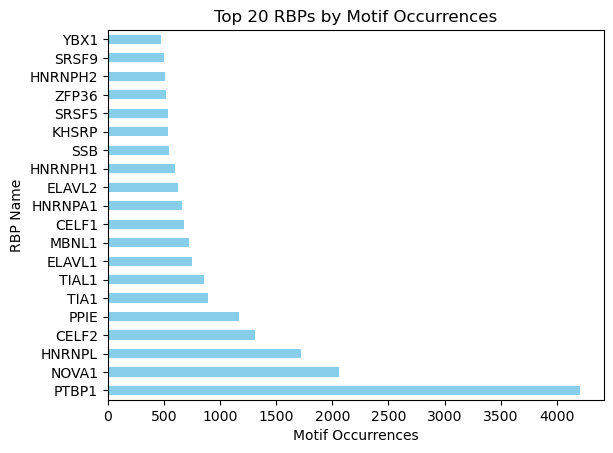

In [18]:
# Plotting a horizontal bar graph for the top 20 RBPs
top_rbps = rbp_counts.head(20)
top_rbps.plot(kind='barh', color='skyblue')
plt.xlabel('Motif Occurrences')
plt.ylabel('RBP Name')
plt.title('Top 20 RBPs by Motif Occurrences')
plt.show()